<a href="https://colab.research.google.com/github/catalina-delgado/Data-Analytics/blob/main/marathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reporte del Analisis de la base de datos Marathon

Mariline Catalina Delgado Martínez

---

## Introducción
Los niveles bajos de sodio han surgido como una de las principales causas de muerte relacionada con la carrera entre los corredores de maratón. Se utilizan datos basados en una cohorte de corredores de maratón de EE.UU. para evaluar los factores que pueden predecir los niveles bajos de sodio sérico. Todos los participantes registrados de 18 años o más eran aptos para su inclusión, y los sujetos fueron abordados al azar durante el registro e invitados a participar. Se analizaron varias variables independientes para determinar su asociación con el nivel de sodio sérico, a saber, la frecuencia de la ingesta de líquidos, el sexo femenino, la edad, el índice de masa corporal, el número de maratones anteriores, el uso de medicamentos antiinflamatorios no esteroideos, el tiempo de carrera del maratón, el ritmo de entrenamiento, el autoinforme de micción durante la carrera, el autoinforme de carga de agua antes de la carrera y el cambio de peso durante la carrera.

---

## Inspección de los Datos

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# read the data
data = pd.read_excel("marathon.xlsx")
data.head(5)

,sodium,female,age,bmi,fluidfr3,howmany,lwobup01,runtime,trainpse,urit3p,wateld01,wtdiff
0,144,0,55.63,20.182332,1.0,1.0,0.0,211.0,470.0,0.0,1.0,-0.45
1,140,0,50.71,25.142973,1.0,4.0,0.0,207.0,460.0,0.0,1.0,-3.18
2,139,0,41.92,25.972011,1.0,0.0,1.0,229.0,495.0,0.0,0.0,2.00
3,134,0,55.84,24.912070,1.0,14.0,NaN,261.0,570.0,0.0,1.0,0.45
4,135,0,30.59,20.717350,1.0,2.0,0.0,173.0,405.0,0.0,1.0,-1.82


1. Eliminación de datos faltantes

La base de datos puede contener datos vacíos en los registros de las variables, por lo tanto se elimnan.

In [ ]:
df = data.dropna()

In [ ]:
filas_con_nulos = df[df.isnull().any(axis=1)]

# Mostrar las filas con valores nulos
print(filas_con_nulos)

Empty DataFrame
Columns: [sodium, female, age, bmi, fluidfr3, howmany, lwobup01, runtime, trainpse, urit3p, wateld01, wtdiff]
Index: []


2. Preprocesamiento de datos

La base de datos Marathon, contiene múltiples variables que pueden incidir sobre la variable de respuesta (nivel de sodio), por lo tanto, para reducir la complejidad computacional y mejorar la precisión de los modelos se utiliza la técnica PCA.

**PCA** Es una técnica que utiliza transformaciones ortogonales para convertir un conjunto de variables correlacionadas a un conjunto de variables independientes.

In [ ]:
#Reducción de dimensionalidad
columnas_seleccionadas = ['howmany', 'lwobup01', 'runtime', 'trainpse', 'urit3p', 'wateld01', 'wtdiff']
data_selected = df[columnas_seleccionadas]
data_std = StandardScaler().fit_transform(data_selected)

pca = PCA(n_components=1)
Factor_PCA = pca.fit_transform(data_std)

## Visualización de Datos

Para visualizar la separación de los datos, se emplea el gráfico de dispersión de datos, clasificado por los niveles de ingesta de líquido y evaluando los niveles de sodio de acuerdo a la edad y el facor PCA, resultado de la reducción

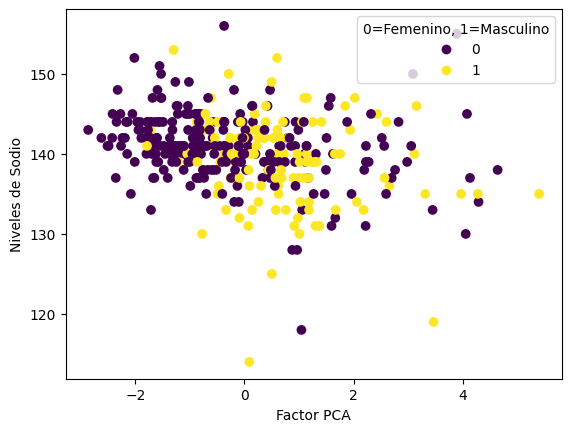

In [ ]:
_, ax = plt.subplots()
scatter = ax.scatter(Factor_PCA, df['sodium'], c=df['female'])
ax.set(xlabel='Factor PCA', ylabel='Niveles de Sodio')
_ = ax.legend(
    scatter.legend_elements()[0], df['female'].unique(), loc="upper right", title="0=Femenino, 1=Masculino"
)

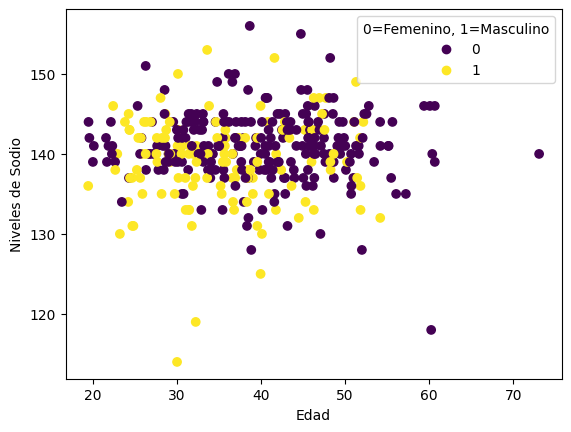

In [ ]:
_, ax = plt.subplots()
scatter = ax.scatter(df['age'], df['sodium'], c=df['female'])
ax.set(xlabel='Edad', ylabel='Niveles de Sodio')
_ = ax.legend(
    scatter.legend_elements()[0], df['female'].unique(), loc="upper right", title="0=Femenino, 1=Masculino"
)

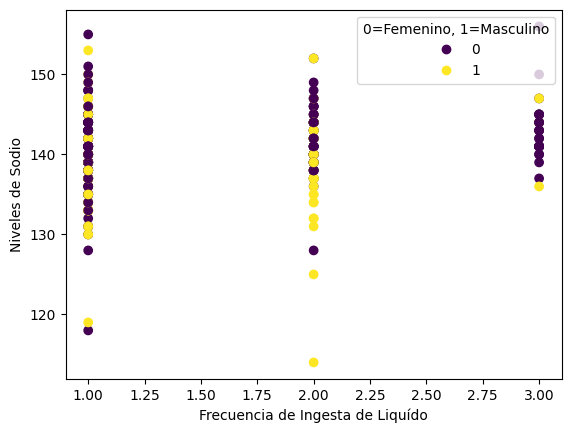

In [ ]:
_, ax = plt.subplots()
scatter = ax.scatter(df['fluidfr3'], df['sodium'], c=df['female'])
ax.set(xlabel='Frecuencia de Ingesta de Liquído', ylabel='Niveles de Sodio')
_ = ax.legend(
    scatter.legend_elements()[0], df['female'].unique(), loc="upper right", title="0=Femenino, 1=Masculino"
)



## Modelo Lineal para ajuste de datos


1. Validadción de Linealidad entre variables (Test de Pearson)

In [ ]:
from scipy.stats import pearsonr
# Correlación lineal entre las dos variables
corr_test = pearsonr(Factor_PCA.flatten(), df['sodium'])
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  -0.2211015822367167
P-value:  1.7721793389401762e-05


In [ ]:
corr_test = pearsonr(df['fluidfr3'], df['sodium'])
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  0.18431311492285918
P-value:  0.00036536073752894656


El gráfico y el test de correlación muestran una relación lineal positiva entre las dos variables con intensidad débil (r = 0.49 y p-value = 0.03) Se rechacha la hipotesis nula de que no hay correlación. Tiene sentido intentar generar un modelo de regresión lineal incluyendo más factores como la edad con el objetivo de predecir el número de sobrevicvientes en función del número de dosis.

2. Ajuste del Modelo

In [ ]:
df['factor'] = Factor_PCA.flatten()
# Se definen las variables dependiente e independiente
y = df['sodium']
X = df[['fluidfr3','female','factor','bmi','age']]

In [ ]:
# Añadir una constante como intercepto del modelo
X = sm.add_constant(X)

In [ ]:
# Ajustar el modelo de regresión lineal
modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                 sodium   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     8.782
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           7.01e-08
Time:                        02:05:06   Log-Likelihood:                -1089.2
No. Observations:                 370   AIC:                             2190.
Df Residuals:                     364   BIC:                             2214.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        135.6121      3.026     44.821      0.0

El modelo con todas las variables introducidas como predictores tiene un  R2 = 0.108, es capaz de explicar el 10,8% de la variabilidad observada en los niveles de sodio. Por lo tanto, se debe evaluar los factores con mayor significancia para predecir la variación en los niveles de sodio de una persona mayor a 18 años.

## Resultados
Se pretende evaluar la incidencia de variables principales como: ingesta de fluido, género, edad, índice de Masa Corporal (IMC) y el factor PCA que reune la correlación del resto de variables en el modelo. Se observa del análisis de varianza que la ingesta de fluidos, y el factor PCA están por debajo del nivel de significancia (alpha=0.05), se rechaza la hipótesis nula de que no hay incidencia sobre los niveles de sodio. Por otro lado, se observa que para el género, la edad y el IMC los p-valores son superiores al nivel de sifnificancia, por lo tanto no inciden significativamente sobre los niveles de sodio.

## Discusión

Estos resultados sugieren los niveles de sodio son idependientes del género y la edad, la dispersión de los datos tanto para el factor PCA y la edad indican que los datos se agrupan en los mismosniveles de sodio. Factores como la ingesta de líquido pueden influir sobre los niveles de sodio en la medida en que a mayor ingesta de líquido menor variabilidad en los niveles de sodio. Esto implica mayor estabilidad.

La correlación del modelo es cercano a 0, esto implica que se puede hacer un mejor ajuste encontrando los factores que más significania presentan sobre los niveles de sodio para correlacionar linealmente los datos experimentales con el modelo ajustado.